/var/folders/kc/3v6snkb12_3dt5pl8j_4y94c0000gn/T/ipykernel_8681/1582605486.py:127: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  valueloss = F.smooth_l1_loss(currentvalue, torch.FloatTensor([currentreturn]))


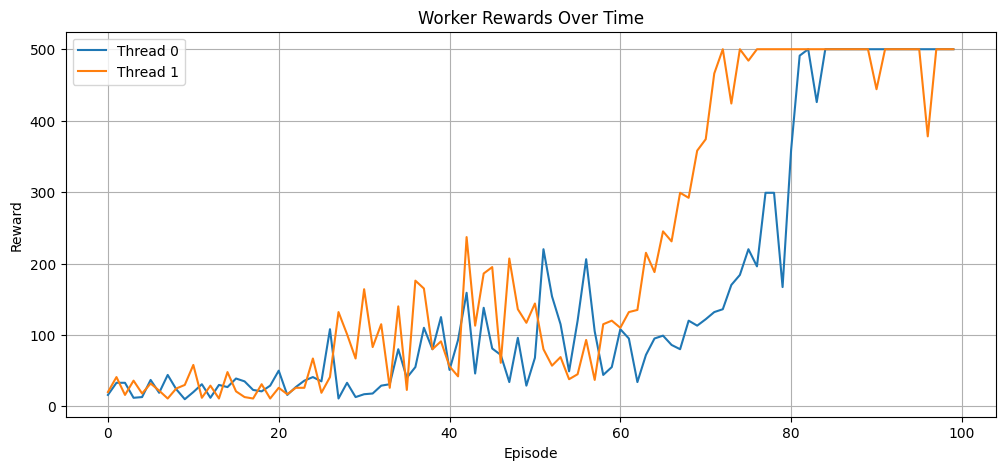

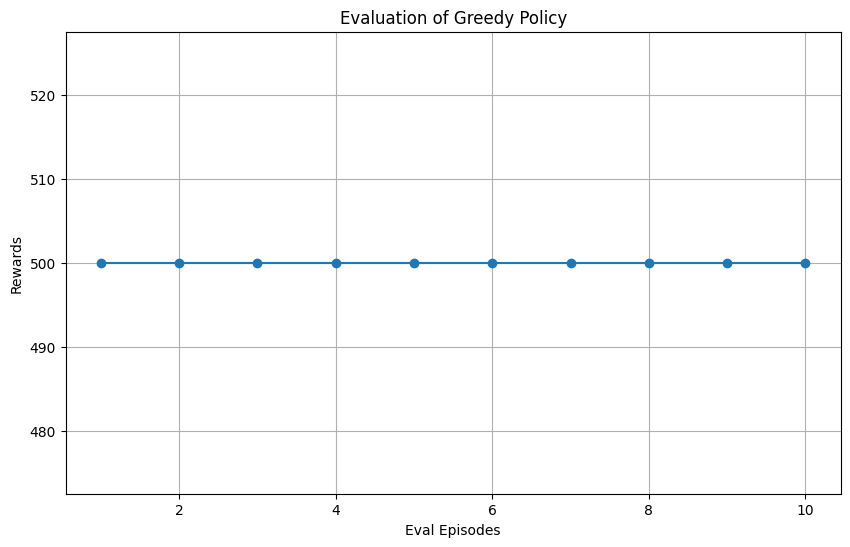

In [5]:
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
import numpy as np
import threading
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import defaultdict
import random

BASESEED = 99
random.seed(BASESEED)
np.random.seed(BASESEED)
torch.manual_seed(BASESEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

globallock = threading.Lock()
workerrews = defaultdict(list)

class Actor(nn.Module):
    def __init__(self, statedim, nactions):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(statedim, 200)
        self.fc2 = nn.Linear(200, 64)
        self.out = nn.Linear(64, nactions)
    
    def forward(self, state):
        x = self.fc1(state)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        logits = self.out(x)
        actionprobs = F.softmax(logits, dim=-1)
        return actionprobs

class Critic(nn.Module):
    def __init__(self, statedim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(statedim, 200)
        self.fc2 = nn.Linear(200, 100)
        self.out = nn.Linear(100, 1)
    
    def forward(self, state):
        x = self.fc1(state)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        value = self.out(x)
        return value

def trainwk(threadid, globalact, globalcrt, actopt, crtopt, totaleps=100):
    threadseed = BASESEED + threadid
    random.seed(threadseed)
    np.random.seed(threadseed)
    torch.manual_seed(threadseed)
    
    localact = Actor(statedim, nactions)
    localcrt = Critic(statedim)
    env = gym.make("CartPole-v1")
    env.reset(seed=threadseed)
    env.action_space.seed(threadseed)
    env.observation_space.seed(threadseed)
    gamma = 0.9  

    episodecounter = 0
    while episodecounter < totaleps:
        localact.load_state_dict(globalact.state_dict())
        localcrt.load_state_dict(globalcrt.state_dict())
        
        currentstate, _ = env.reset(seed=threadseed + episodecounter)
        episodefinished = False
        episodereward = 0
        actionlogprobs = []
        valueestimates = []
        collectedrewards = []

        while not episodefinished:
            currentstatetensor = torch.FloatTensor(currentstate)
            currentstatebatch = currentstatetensor.unsqueeze(0)
            
            actionprobabilities = localact(currentstatebatch)
            statevalue = localcrt(currentstatebatch)
            
            probabilitydistribution = torch.distributions.Categorical(actionprobabilities)
            selectedaction = probabilitydistribution.sample()
            actionlogprobability = probabilitydistribution.log_prob(selectedaction)
            
            nextstate, reward, terminalstate, truncatedstate, _ = env.step(selectedaction.item())
            episodefinished = terminalstate or truncatedstate
            
            episodereward += reward
            actionlogprobs.append(actionlogprobability)
            valueestimates.append(statevalue)
            collectedrewards.append(reward)
            currentstate = nextstate

            if episodefinished:
                with globallock:
                    workerrews[threadid].append(episodereward)
                
                accumulatedreturn = 0
                allreturns = []
                rewardindex = len(collectedrewards) - 1
                
                while rewardindex >= 0:
                    currentreward = collectedrewards[rewardindex]
                    accumulatedreturn = currentreward + gamma * accumulatedreturn
                    allreturns.insert(0, accumulatedreturn)
                    rewardindex -= 1
                
                returnstensor = torch.FloatTensor(allreturns)
                returnsnormalized = (returnstensor - returnstensor.mean()) / (returnstensor.std() + 1e-5)
                
                policylosses = []
                valuelosses = []
                
                for stepidx in range(len(actionlogprobs)):
                    currentlogprob = actionlogprobs[stepidx]
                    currentvalue = valueestimates[stepidx]
                    currentreturn = returnsnormalized[stepidx]
                    
                    advantage = currentreturn - currentvalue.detach()
                    policyloss = -currentlogprob * advantage
                    valueloss = F.smooth_l1_loss(currentvalue, torch.FloatTensor([currentreturn]))
                    
                    policylosses.append(policyloss)
                    valuelosses.append(valueloss)
                
                with globallock:
                    actopt.zero_grad()
                    policylossstack = torch.stack(policylosses)
                    policylossmean = torch.mean(policylossstack)
                    policylossmean.backward()
                    
                    for globalparam, localparam in zip(globalact.parameters(), localact.parameters()):
                        if globalparam.grad is None:
                            globalparam.grad = localparam.grad
                    
                    actopt.step()
                    
                    crtopt.zero_grad()
                    valuelossstack = torch.stack(valuelosses)
                    valuelossmean = torch.mean(valuelossstack)
                    valuelossmean.backward()
                                        
                    for globalparam, localparam in zip(globalcrt.parameters(), localcrt.parameters()):
                        if globalparam.grad is None:
                            globalparam.grad = localparam.grad
                    
                    crtopt.step()
        
        episodecounter += 1

def evalpolicy(actornet, numevaleps=10):
    evalseed = BASESEED + 1000
    random.seed(evalseed)
    np.random.seed(evalseed)
    torch.manual_seed(evalseed)
    
    env = gym.make("CartPole-v1")
    env.reset(seed=evalseed)
    env.action_space.seed(evalseed)
    env.observation_space.seed(evalseed)
    
    evaluationrewards = []
    episodecounter = 0
    
    while episodecounter < numevaleps:
        currentstate, _ = env.reset(seed=evalseed + episodecounter)
        episodefinished = False
        accumulatedreward = 0
        
        while not episodefinished:
            currentstatetensor = torch.FloatTensor(currentstate)
            currentstatebatch = currentstatetensor.unsqueeze(0)
            
            with torch.no_grad():
                actionprobabilities = actornet(currentstatebatch)
            
            bestaction = torch.argmax(actionprobabilities).item()
            nextstate, reward, terminalstate, truncatedstate, _ = env.step(bestaction)
            
            episodefinished = terminalstate or truncatedstate
            accumulatedreward += reward
            currentstate = nextstate
        
        evaluationrewards.append(accumulatedreward)
        episodecounter += 1
    
    return evaluationrewards

def plotworkerrews():
    plt.figure(figsize=(12, 5))
    for workerid in workerrews.keys():
        rewardhistory = workerrews[workerid]
        plt.plot(rewardhistory, label=f'Thread {workerid}')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Worker Rewards Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

def plotevalrews(evaluationrewards):
    plt.figure(figsize=(10, 6))
    episodenumbers = []
    episodecounter = 1
    
    for _ in evaluationrewards:
        episodenumbers.append(episodecounter)
        episodecounter += 1
    
    plt.plot(episodenumbers, evaluationrewards, marker='o')
    plt.xlabel('Eval Episodes')
    plt.ylabel('Rewards')
    plt.title('Evaluation of Greedy Policy')
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    env = gym.make("CartPole-v1")
    statedim = env.observation_space.shape[0]
    nactions = env.action_space.n
    .
    sharedact = Actor(statedim, nactions)
    sharedcrt = Critic(statedim)
    sharedact.share_memory()
    sharedcrt.share_memory()
    
    lr = 0.0005  
    actopt = optim.Adam(sharedact.parameters(), lr=lr)
    crtopt = optim.Adam(sharedcrt.parameters(), lr=lr)
    
    nthreads = 2
    threads = []
    threadcounter = 0
    
    while threadcounter < nthreads:
        newthread = threading.Thread(
            target=trainwk,
            args=(threadcounter, sharedact, sharedcrt, actopt, crtopt)
        )
        threads.append(newthread)
        newthread.start()
        threadcounter += 1
    
    for activethread in threads:
        activethread.join()
    
    plotworkerrews()
    evaluationrewards = evalpolicy(sharedact, numevaleps=10)
    plotevalrews(evaluationrewards)

In [7]:
torch.save(sharedact.state_dict(), "actor_weights.pth")
torch.save(sharedcrt.state_dict(), "critic_weights.pth")